# Prueba de PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Dataframe
test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET])  # Características
y = train_data[TARGET]  # Valor a estimar

# Dividir en datos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

class SimpleNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=64, lr=0.001, epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if(torch.device == "cpu"):
            print("cpu")
        else:
            print("gpu")

        # Red neuronal
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def fit(self, X, y):
        # X y y son ahora ndarray
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)

        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            predictions = self.model(X_tensor)
            loss = self.criterion(predictions, y_tensor)
            loss.backward()
            self.optimizer.step()

        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.cpu().numpy()


# Crear el modelo con los parámetros deseados
model_params = {'hidden_dim': 64, 'lr': 0.001, 'epochs': 40}

# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            # Imputar valores faltantes y luego estandarizar los datos numéricos
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),  # Usar la media para imputar
                ('scaler', StandardScaler())
            ]), numeric_features),

            # Imputar valores faltantes en los datos categóricos y aplicar OneHotEncoder
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),  # Usar la moda para imputar
                ('onehot', OneHotEncoder())
            ]), categorical_features),

            # Imputar valores faltantes y luego estandarizar los datos binarios
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),  # Usar la moda para imputar
                ('scaler', StandardScaler())
            ]), binary_features)
        ])
    
    # Ajusta el preprocesador a los datos de entrenamiento
    preprocessor.fit(x_train)
    
    # Verificar la forma de los datos después del preprocesamiento
    x_train_transformed = preprocessor.transform(x_train)
    
    input_dim = x_train_transformed.shape[1]  # Número de características después del preprocesamiento
    model = SimpleNN(input_dim=input_dim, hidden_dim=128, lr=0.00001, epochs=50000)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline


pipeline = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Hacer predicciones
y_pred = pipeline.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")

gpu


/home/alexrf14/.conda/envs/rocm_env/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Mean Squared Error (MSE): 143.50543806504933
Median Absolute Error (MedAE): 4.229576533203129


/home/alexrf14/.conda/envs/rocm_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/home/alexrf14/.conda/envs/rocm_env/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


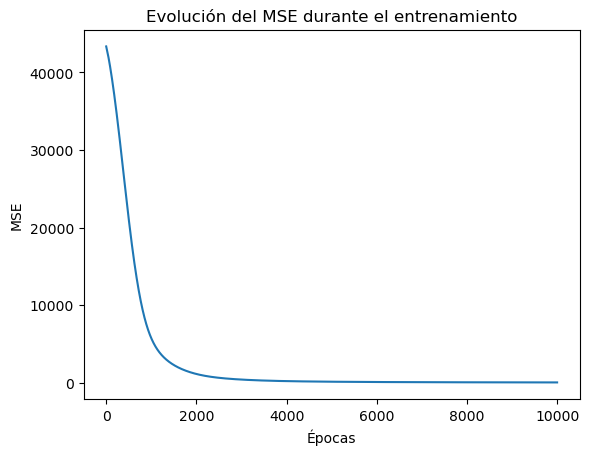

Mean Squared Error (MSE): 110.27751100677634
Median Absolute Error (MedAE): 4.1697557421874905
R² Score: 0.9661624472750203


/home/alexrf14/.conda/envs/rocm_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET])  # Características
y = train_data[TARGET]

class SimpleNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dim=64, lr=0.001, epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Red neuronal
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.loss_history = []

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)

        for epoch in range(self.epochs):
            self.model.train()
            self.optimizer.zero_grad()
            predictions = self.model(X_tensor)
            loss = self.criterion(predictions, y_tensor)
            loss.backward()
            self.optimizer.step()

            # Guardar el MSE de cada época
            self.loss_history.append(loss.item())

        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.cpu().numpy()

# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())
            ]), categorical_features),
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]), binary_features)
        ])
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    preprocessor.fit(x_train)
    x_train_transformed = preprocessor.transform(x_train)
    input_dim = x_train_transformed.shape[1]
    model = SimpleNN(input_dim=input_dim, hidden_dim=1028, lr=0.00002, epochs=10000)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline, x_train, x_test, y_train, y_test

pipeline, x_train, x_test, y_train, y_test = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Graficar la evolución del MSE
model = pipeline.named_steps['model']  # Obtener el modelo entrenado
plt.plot(model.loss_history)
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante el entrenamiento')
plt.show()

# Hacer predicciones
y_pred = pipeline.predict(x_test)

# Calcular y mostrar MSE y MedAE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)



### Creamos más capas + Regulaciones + Drop Out

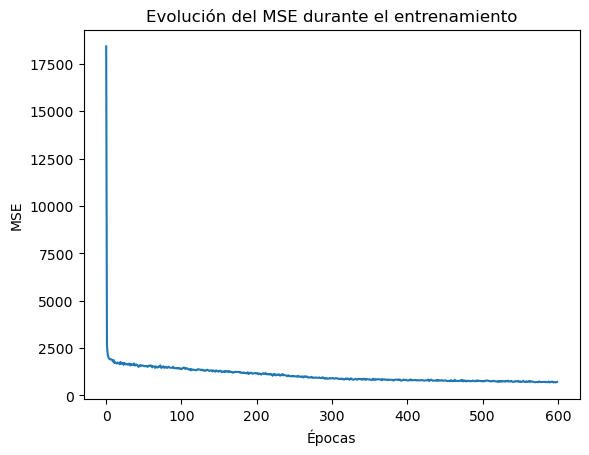

Mean Squared Error (MSE): 171.4121414977071
Median Absolute Error (MedAE): 7.477329030761723
R² Score: 0.9474038965635168


/home/alexrf14/.conda/envs/rocm_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np



test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET])  # Características
y = train_data[TARGET]

class SimpleNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], lr=0.001, epochs=100, batch_size=32, activation='ReLU', dropout=0.0):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.dropout = dropout
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Definir las capas de la red neuronal
        layers = []
        prev_dim = self.input_dim

        for hidden_dim in self.hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if self.activation == 'ReLU':
                layers.append(nn.ReLU())
            elif self.activation == 'Tanh':
                layers.append(nn.Tanh())
            elif self.activation == 'Sigmoid':
                layers.append(nn.Sigmoid())
            elif self.activation == 'LeakyReLU':
                layers.append(nn.LeakyReLU())
            if self.dropout > 0:
                layers.append(nn.Dropout(self.dropout))
            prev_dim = hidden_dim

        # Capa de salida
        layers.append(nn.Linear(prev_dim, 1))

        # Crear el modelo secuencial
        self.model = nn.Sequential(*layers).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.loss_history = []

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            for X_batch, y_batch in dataloader:
                self.optimizer.zero_grad()
                predictions = self.model(X_batch)
                loss = self.criterion(predictions, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            self.loss_history.append(epoch_loss / len(dataloader))

        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.cpu().numpy()

# Crear el pipeline de preprocesamiento y modelo
# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())
            ]), categorical_features),
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]), binary_features)
        ])
    
    # Dividir los datos en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Asegúrate de ajustar el preprocesador antes de cualquier transformación
    preprocessor.fit(x_train)

    # Transformar los datos de entrenamiento
    x_train_transformed = preprocessor.transform(x_train)
    input_dim = x_train_transformed.shape[1]

    # Crear el modelo
    model = SimpleNN(input_dim=input_dim ,lr = 0.0009, hidden_dims= [64, 32, 16], epochs = 500, dropout = 0.2, batch_size = 64, activation = 'ReLU')

    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline, x_train, x_test, y_train, y_test

# Crear el pipeline
pipeline, x_train, x_test, y_train, y_test = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

# Entrenar el modelo
pipeline.fit(x_train, y_train)

# Graficar la evolución del MSE
model = pipeline.named_steps['model']  # Obtener el modelo entrenado
plt.plot(model.loss_history)
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante el entrenamiento')
plt.show()

# Hacer predicciones
y_pred = pipeline.predict(x_test)

# Calcular y mostrar MSE y MedAE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)


### Prueba de parámetros

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

# Leer los datos
test_data = pd.read_csv("public_test.csv")
train_data = pd.read_csv("public_train.csv")

# Identificar columnas
TARGET = "ccs"
CATEGORICAL_FEATURES = ["adduct"]
NUMERIC_FEATURES = [col for col in train_data.columns if col.startswith("desc_")]
BINARY_FEATURES = [col for col in train_data.columns if col.startswith("fgp_")]

# Separar características y objetivo
x = train_data.drop(columns=[TARGET])  # Características
y = train_data[TARGET]

# Definir el modelo
class SimpleNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_dims=[64, 32, 16], lr=0.001, epochs=100, batch_size=32, activation='ReLU', dropout=0.0):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.dropout = dropout
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.device.type == "cpu":
            print("Using CPU")
        else:
            print("Using GPU")

        layers = []
        prev_dim = self.input_dim
        for hidden_dim in self.hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(getattr(nn, self.activation)())
            if self.dropout > 0:
                layers.append(nn.Dropout(self.dropout))
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()
        self.loss_history = []

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(self.device)

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            epoch_loss = 0
            for X_batch, y_batch in dataloader:
                self.optimizer.zero_grad()
                predictions = self.model(X_batch)
                loss = self.criterion(predictions, y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            self.loss_history.append(epoch_loss / len(dataloader))

        return self

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            predictions = self.model(X_tensor)
        return predictions.cpu().numpy()

# Crear el pipeline de preprocesamiento y modelo
def create_preproc_and_model(numeric_features, categorical_features, binary_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())
            ]), categorical_features),
            ('bin', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]), binary_features)
        ]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    preprocessor.fit(x_train)
    x_train_transformed = preprocessor.transform(x_train)
    input_dim = x_train_transformed.shape[1]

    # Convertir x_train y x_test a DataFrames para que ColumnTransformer pueda funcionar
    x_train = pd.DataFrame(x_train, columns=train_data.drop(columns=[TARGET]).columns)
    x_test = pd.DataFrame(x_test, columns=train_data.drop(columns=[TARGET]).columns)

    model = SimpleNN(input_dim=input_dim, hidden_dims=[128, 64, 32], lr=0.0001, epochs=500, batch_size=64, activation='LeakyReLU', dropout=0.3)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline, x_train, x_test, y_train, y_test

# Crear y configurar el RandomizedSearchCV
pipeline, x_train, x_test, y_train, y_test = create_preproc_and_model(NUMERIC_FEATURES, CATEGORICAL_FEATURES, BINARY_FEATURES)

param_dist = {
    'model__hidden_dims': [[128, 64, 32], [64, 32, 16], [256, 128, 64]],
    'model__lr': [0.01, 0.001, 0.0001, 0.00001],
    'model__epochs': [100, 500, 1000],
    'model__batch_size': [32, 64, 128],
    'model__activation': ['ReLU', 'LeakyReLU'],
    'model__dropout': [0.0, 0.2, 0.3, 0.5]
}

medae_scorer = make_scorer(median_absolute_error, greater_is_better=False)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    random_state=42,
    n_jobs=-1,
    scoring=medae_scorer
)

random_search.fit(x_train, y_train)

print("Mejores parámetros encontrados:", random_search.best_params_)

y_pred = random_search.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error (MedAE): {medae}")

r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

# Graficar la evolución del MSE
best_model = random_search.best_estimator_.named_steps['model']
plt.plot(best_model.loss_history)
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante el entrenamiento')
plt.show()


Investigar torch.profiler y DataLoader